# Train and test Graph Convolutional Network (GCN) in histology classfication

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Packages for graph construction

sklearn.neightbors: https://kite.com/python/docs/sklearn.neighbors.graph.kneighbors_graph

networkX: https://networkx.github.io/documentation/stable/tutorial.html

about sparse matrix: https://stackoverflow.com/questions/48492331/accessing-elements-in-an-sklearn-sparse-array

In [2]:
import sklearn.neighbors.graph as skgraph
from scipy import sparse as sp
import networkx as nx

## Packages and class for constructing torch geometric graph

In [3]:
import torch
import torch_geometric
from torch_geometric.data import Data

In [4]:
class NucleiData(Data):
    """Add some attributes to Data object.
    
    Args:
        * All args mush be torch.tensor. So string is not supported.
        x: Matrix for nodes
        cell_type: cell type
        edge_index: 2*N matrix
        edge_attr: edge type
        y: Label
        pid: Patient ID
        region_id: Region ID, range from 0~99
    """
    def __init__(self, x=None, cell_type=None, edge_index=None, edge_attr=None, y=None, pos=None, pid=None, region_id=None):
        super().__init__(x, edge_index, edge_attr, y, pos)
        self.cell_type = cell_type
        self.pid = pid
        self.region_id = region_id
        
    def __repr__(self):
        info = ['{}={}'.format(key, self.size_repr(item)) for key, item in self]
        return '{}({})'.format(self.__class__.__name__, ', '.join(info))
    
    @staticmethod
    def size_repr(value):
        if torch.is_tensor(value):
            return list(value.size())
        elif isinstance(value, int) or isinstance(value, float) or isinstance(value, str):
            return [1]
        else:
            raise ValueError('Unsupported attribute type.')

# 1) Create torch graph dataset

Create data list for each nuclei_data

In [6]:
nlst_data_dir = "/project/bioinformatics/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/NLST_ADC_100_patches_updated/"
tcga_luad_data_dir = "/project/bioinformatics/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUAD_100_patches_updated/"
tcga_lusc_data_dir = "/project/bioinformatics/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUSC_100_patches"

In [7]:
x_ave = np.array([2.62e+02, 2.76e+02, # area, convex_area, 
                   7.44e-01, 7.02e-01, 2.62e+02, 2.32e+01,  # eccentricity, extent, filled_area, major_axis_length
                   1.32e+01, 1.54e+01, 5.97e+01, 8.63e-01,  # minor_axis_length, pa_ratio, perimeter, probability
                   9.52e-01])  # solidity

x_std = np.array([2.34e+02, 2.49e+02,  # area, convex_area,
                   1.61e-01, 1.04e-01, 2.34e+02, 1.13e+01,  # eccentricity, extent, filled_area, major_axis_length
                   5.31e+00, 4.07e+00, 2.76e+01, 7.25e-02,  # minor_axis_length, pa_ratio, perimeter, probability
                   3.78e-02])   # solidity

In [8]:
def get_edge_type(edge, cell_type):
    """
    Args: 
        edge: (in_cell_index, out_cell_index, 1/edge_length)
        
    Returns:
        edge type index.
        0: 1-1; 1: 1-2; 2: 1-3; 3: 1-4; 4: 1-5; 5: 1-6
        6: 2-1; 7: 2-2; 8: 2-3; 9: 2-4; 10: 2-5; 11: 2-6
        12: 3-1; 13: 3-2; 14: 3-3; 15: 3-4; 16: 3-5; 17: 3-6
        18: 4-1; 19: 4-2; 20: 4-3; 21: 4-4; 22: 4-5; 23: 4-6
        24: 5-1; 25: 5-2; 26: 5-3; 27: 5-4; 28: 5-5; 29: 5-6
        30: 6-1; 31: 6-2; 32: 6-3; 33: 6-4; 34: 6-5; 35: 6-6
    """
    mapping = {"1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4, "1-6": 5,
                   "2-1": 6, "2-2": 7, "2-3": 8, "2-4": 9, "2-5": 10, "2-6": 11,
                   "3-1": 12, "3-2": 13, "3-3": 14, "3-4": 15, "3-5": 16, "3-6": 17,
                   "4-1": 18, "4-2": 19, "4-3": 20, "4-4": 21, "4-5": 22, "4-6": 23,
                   "5-1": 24, "5-2": 25, "5-3": 26, "5-4": 27, "5-5": 28, "5-6": 29,
                   "6-1": 30, "6-2": 31, "6-3": 32, "6-4": 33, "6-5": 34, "6-6": 35}
    return mapping['{}-{}'.format(cell_type[edge[0]], cell_type[edge[1]])]

def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]])

## 1.1) Create TCGA_LUAD torch graph dataset

In [11]:
tcga_luad_slide_names = os.listdir(tcga_luad_data_dir)
tcga_luad_dataset = []
for i, slide_name in enumerate(tcga_luad_slide_names):
    slide_dir = os.path.join(tcga_luad_data_dir, slide_name)
    cell_summary_file = [_ for _ in os.listdir(slide_dir)
                        if re.search("cell_summary_(20|40)X_100patches.csv", _) is not None]
    if not len(cell_summary_file):
        print("cell summary file not found")
        continue
    
    cell_summary_file = cell_summary_file[0]
    if os.path.exists(os.path.join(tcga_luad_data_dir, slide_name, cell_summary_file)):
        print(i, slide_name)
        cell_summary = pd.read_csv(os.path.join(tcga_luad_data_dir, slide_name, cell_summary_file))
        # patch_coords = pd.read_csv(os.path.join(tcga_luad_data_dir, slide_name, "patch_summary_40X_100patches.csv"))
        
        for region_id in range(100):
            try:
                patch_summary = cell_summary[cell_summary['n_patch'] == region_id]
                # coord_x, coord_y = patch_coords.loc[region_id, ["coordinate_x", "coordinate_y"]].values
                if sum(patch_summary['cell_type'] == 1) < 20:
                    # Only process the patches with >= 20 tumor cells
                    continue
                    # raise Exception("Too few tumor cells.")
                
                # Create 8 nearest neighbors graph
                graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                                 n_neighbors=8, mode='distance')
                I, J, V = sp.find(graph)
                edges = list(zip(I, J, 1/V))
                edge_index = np.transpose(np.array(edges)[:, 0:2])
                x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                                   'eccentricity', 'extent', 'filled_area', 
                                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
                cell_type = np.array(patch_summary['cell_type'])
                orientation = np.array(patch_summary['orientation'])
                
                # Edge features
                edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
                nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
                edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))
                
                data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                                  y=torch.tensor([[0]]),
                                  pid=torch.tensor([[i]]),
                                  region_id=torch.tensor([[region_id]]))
                tcga_luad_dataset.append(data)
            except Exception as e:
                print(e)
                continue
torch.save(tcga_luad_dataset, "./data/TCGA_LUAD_8neighbors_100regions_1024_1024_updated_2.pt")

0 TCGA-99-7458-01Z-00-DX1.10ea0b2c-c763-40d1-83a4-3d4ae957fdb0.svs
1 TCGA-97-8179-01Z-00-DX1.5501338a-dd89-4c41-8267-5baaaea71643.svs
2 TCGA-53-7624-01Z-00-DX1.51b4de19-3531-4bcb-b822-fa966480f2ad.svs
3 TCGA-38-4631-01Z-00-DX1.B331ACB6-3831-4FB3-A2B4-9276D261E5A7.svs
4 TCGA-55-8513-01Z-00-DX1.E21776FE-DF49-48D1-90D6-6F71D0764492.svs
5 TCGA-86-8668-01Z-00-DX1.d720d486-02c7-4f98-8feb-e0e50a12c158.svs
6 TCGA-55-6980-01Z-00-DX1.2f1d1858-42b9-4e3b-966d-2f3f429570a6.svs
7 TCGA-78-7539-01Z-00-DX1.b838d859-2fb7-48d1-a442-d366ac404099.svs
8 TCGA-86-7714-01Z-00-DX1.8ee03c3b-013e-4dd5-aa0e-9c1a771cbdc5.svs
9 TCGA-86-8671-01Z-00-DX1.1fd0019c-df9d-48cc-9055-8de57759f273.svs
10 TCGA-49-4501-01Z-00-DX3.b6c2cc84-1c94-4816-92e7-8cf4446ac9ac.svs
11 TCGA-69-8453-01Z-00-DX1.C472096B-95BA-42CD-ADEB-326C38F9DC95.svs
12 TCGA-69-8254-01Z-00-DX1.83a81d08-8c70-4f07-b4da-cbd17c4fe4d4.svs
13 TCGA-L4-A4E5-01Z-00-DX1.C2A5EF71-1F40-4E34-AC30-58D7121C1338.svs
14 TCGA-53-A4EZ-01Z-00-DX1.5D155F0B-A677-4589-AF00-A4C451F

121 TCGA-78-7149-01Z-00-DX1.1b83dbcb-0c9f-4e50-bb98-bf9a157052cf.svs
122 TCGA-86-6851-01Z-00-DX1.0b13e600-fd7b-44a2-9ec2-26e9938fb7bc.svs
123 TCGA-95-A4VN-01Z-00-DX1.B997A80F-C396-40AB-808A-B70EB83A2B74.svs
124 TCGA-55-8621-01Z-00-DX1.7C519007-D59D-432A-BF4D-23D14A1C8BB6.svs
125 TCGA-55-6986-01Z-00-DX1.ae52d41e-3cd6-4d36-b04b-2ea7d29bd8da.svs
126 TCGA-95-8039-01Z-00-DX1.38b07435-987d-495d-9940-ba5f20e6ef97.svs
127 TCGA-53-7813-01Z-00-DX1.97c5eff3-ceeb-499b-b2e1-bcd3cd60c5e7.svs
128 TCGA-95-7043-01Z-00-DX1.AE0FD8AA-9B88-45FE-B247-402BED1285EF.svs
129 TCGA-44-7672-01Z-00-DX1.71f4a0c6-a9cc-481c-ace8-c8c314952aa1.svs
130 TCGA-49-4505-01Z-00-DX2.48df81e7-5a8e-4c5b-993a-6a54481a35e9.svs
131 TCGA-L4-A4E6-01Z-00-DX1.1B537DE0-2CE3-4B90-9ED3-71F1F8747EE9.svs
132 TCGA-55-8092-01Z-00-DX1.04e44341-c4bb-4b0b-965c-7ec83f3877a6.svs
133 TCGA-69-7979-01Z-00-DX1.c9bc265d-4889-4333-9852-b8b535887f1e.svs
134 TCGA-49-4514-01Z-00-DX4.79e9e14e-72ea-4e9f-9719-d1a791cf0b43.svs
135 TCGA-78-7150-01Z-00-DX1.46e6e6

240 TCGA-67-3774-01Z-00-DX1.FE85FDCB-91D2-47C5-8D13-D622A51A7BE0.svs
241 TCGA-55-6975-01Z-00-DX1.2762a872-b1c3-47fd-8ed5-b715a5b20163.svs
242 TCGA-55-7913-01Z-00-DX1.2295fcc5-70b0-412e-a1fd-b5366fce0739.svs
243 TCGA-64-5781-01Z-00-DX1.81474D4D-6B48-473F-BAA9-ABD75C9223C3.svs
244 TCGA-49-6742-01Z-00-DX2.2c6b4df0-867d-40c5-8bee-14e2d219224b.svs
245 TCGA-50-6673-01Z-00-DX1.e24fb432-3fff-4f00-a316-16d05275c1e7.svs
246 TCGA-44-A479-01Z-00-DX1.CA5654C6-A623-452E-A8AC-DB6279CA97B1.svs
247 TCGA-55-7725-01Z-00-DX1.4d678777-63b1-4f4a-932a-7fccabf504c7.svs
248 TCGA-62-A46U-01Z-00-DX1.5129535F-8B6A-4647-8A88-3EE125642874.svs
249 TCGA-05-4396-01Z-00-DX1.49DD5F68-7473-4945-B384-EA6D5AE383CB.svs
250 TCGA-55-8091-01Z-00-DX1.0996c58a-6e93-4092-8cb8-014d548fe60c.svs
251 TCGA-55-8507-01Z-00-DX1.3C6198CF-3E13-4C4C-B851-5BDFF8552621.svs
252 TCGA-55-7914-01Z-00-DX1.875bffe1-8c56-4c29-ab11-6840ee3a643c.svs
253 TCGA-55-7576-01Z-00-DX1.3a6142e9-c90a-4938-a1d1-061c2ac261f0.svs
254 TCGA-78-8655-01Z-00-DX1.DC81D1

359 TCGA-78-7146-01Z-00-DX1.830209b2-94c5-4277-a7b6-b2f2634de0dc.svs
360 TCGA-49-6742-01Z-00-DX1.23e8883f-0ecc-4359-a8b5-75d49f43a08b.svs
361 TCGA-44-7659-01Z-00-DX1.818bf5b3-b4c1-4d23-a6ae-98d5015eb8c1.svs
362 TCGA-55-6983-01Z-00-DX1.8f940a64-1f1b-4e6e-99ea-418175be2b3f.svs
363 TCGA-L9-A8F4-01Z-00-DX1.E2BBB8DE-94E2-4781-9B55-8A4CFBF8A69D.svs
364 TCGA-49-6742-01Z-00-DX4.a11201e1-9eeb-40ea-9c88-28de847ef7d8.svs
365 TCGA-62-A46R-01Z-00-DX1.AD823FBA-A63F-4D36-8B84-2C995DE5FC47.svs
366 TCGA-62-A46O-01Z-00-DX1.39B361AD-ED1D-4C0C-8611-0E8CCBDBD252.svs
367 TCGA-55-A48Z-01Z-00-DX1.0867DC6A-2A51-4CF1-AE3F-0526CE2DD740.svs
368 TCGA-86-A4P7-01Z-00-DX1.37026DCF-5A81-4098-B444-C8A40CA168D0.svs
369 TCGA-69-7980-01Z-00-DX1.8bbf8cc0-eca7-49e5-a022-c22e3e6ed6dc.svs
370 TCGA-44-A47A-01Z-00-DX1.62448803-3A7B-41EC-9794-67916DA0792E.svs
371 TCGA-44-6774-01Z-00-DX1.f169485b-f863-4be0-9844-258d78170b64.svs
372 TCGA-MN-A4N4-01Z-00-DX1.7D8352EF-7A4B-4084-9612-CF92D9D16041.svs
373 TCGA-86-8073-01Z-00-DX1.33c016

## 1.2) Create TCGA_LUSC torch graph dataset

In [12]:
tcga_lusc_slide_names = os.listdir(tcga_lusc_data_dir)
tcga_lusc_dataset = []
for i, slide_name in enumerate(tcga_lusc_slide_names):
    if os.path.exists(os.path.join(tcga_lusc_data_dir, slide_name, "cell_summary_40X_100patches.csv")):
        print(i, slide_name)
        cell_summary = pd.read_csv(os.path.join(tcga_lusc_data_dir, slide_name, "cell_summary_40X_100patches.csv"))
        # patch_coords = pd.read_csv(os.path.join(tcga_lusc_data_dir, slide_name, "patch_summary_40X_100patches.csv"))
        
        for region_id in range(100):
            try:
                patch_summary = cell_summary[cell_summary['which_patch'] == region_id]
                # coord_x, coord_y = patch_coords.loc[region_id, ["coordinate_x", "coordinate_y"]].values
                if sum(patch_summary['cell_type'] == 1) < 20:
                    # Only process the patches with >= 20 tumor cells
                    continue
                    # raise Exception("Too few tumor cells.")
                
                # Create 8 nearest neighbors graph
                graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                                 n_neighbors=8, mode='distance')
                I, J, V = sp.find(graph)
                edges = list(zip(I, J, 1/V))
                edge_index = np.transpose(np.array(edges)[:, 0:2])
                x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                                   'eccentricity', 'extent', 'filled_area', 
                                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
                cell_type = np.array(patch_summary['cell_type'])
                orientation = np.array(patch_summary['orientation'])
                
                # Edge features
                edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
                nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
                edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))
                
                data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                                  y=torch.tensor([[1]]),
                                  pid=torch.tensor([[i]]),
                                  region_id=torch.tensor([[region_id]]))
                tcga_lusc_dataset.append(data)
            except Exception as e:
                print(e)
                continue
torch.save(tcga_lusc_dataset, "./data/TCGA_LUSC_8neighbors_100regions_1024_1024_2.pt")

0 TCGA-22-4605-01Z-00-DX1.5B725941-80CE-497B-8A1E-856D16DD2870.svs
1 TCGA-68-7757-01Z-00-DX1.4eece254-a119-436a-af3c-fad8e8b7f74b.svs
2 TCGA-6A-AB49-01Z-00-DX1.FDF2EED7-57A3-4019-A382-21DED11780F6.svs
5 TCGA-85-8352-01Z-00-DX1.47426016-95BC-49C0-9844-06A3A7EAE5D6.svs
6 TCGA-66-2795-01Z-00-DX1.4141cb69-b675-49c4-85c5-21d630b5143d.svs
7 TCGA-60-2697-01Z-00-DX1.e11a5b5b-c4be-4fe1-b7db-08879e55d552.svs
8 TCGA-77-8143-01Z-00-DX1.e844a7e1-ebba-4acb-8fe2-08aee2102848.svs
9 TCGA-22-5480-01Z-00-DX1.A6E25FF1-9616-4F5F-97BD-BA1912C46008.svs
10 TCGA-77-8145-01Z-00-DX1.9d76de05-3cb7-4cd8-879b-11ea7f88d583.svs
11 TCGA-LA-A446-01Z-00-DX1.0DC9ABAF-2FED-4F4E-B453-299441CEC607.svs
14 TCGA-60-2703-01Z-00-DX1.13cdede5-0135-4e05-9478-3b728cad247e.svs
15 TCGA-77-8128-01Z-00-DX1.5831331a-8c82-4817-977e-1842250d9c7b.svs
16 TCGA-NC-A5HH-01Z-00-DX1.4138DC62-3487-4F4B-8D5C-D7693B303387.svs
17 TCGA-33-AASJ-01Z-00-DX1.0201CE2A-4DE6-4B4E-A010-37D773207F52.svs
18 TCGA-85-8666-01Z-00-DX1.d856233a-beef-4da2-a724-759fe

141 TCGA-56-A4ZK-01Z-00-DX1.D6B1AC68-BF70-4C49-A5A1-233D6DA4AE27.svs
142 TCGA-85-8288-01Z-00-DX1.0e68535f-a1f3-450c-b8fa-a859f2269da8.svs
143 TCGA-O2-A52W-01Z-00-DX1.3D388EB0-8402-4540-9E50-7C3757FA5D83.svs
144 TCGA-98-A539-01Z-00-DX1.420AA419-0146-4991-B98D-28E647E45F07.svs
145 TCGA-85-8353-01Z-00-DX1.2A333CFA-3D8A-41B2-9D08-8AAF431BFE54.svs
146 TCGA-77-7140-01Z-00-DX1.e75db0f0-839e-4ade-aa52-aa4736318d6c.svs
147 TCGA-33-4586-01Z-00-DX2.a9798fe4-8db9-41d7-8d00-eb2a9eef1bc0.svs
148 TCGA-66-2773-01Z-00-DX1.70fe76fc-749d-4720-a97e-40cd097f2340.svs
149 TCGA-66-2766-01Z-00-DX1.05729d5f-7c12-44e1-9a61-90296f555e89.svs
150 TCGA-18-4083-01Z-00-DX1.337D4583-326F-4108-9441-DC74FAED6AE2.svs
152 TCGA-43-3920-01Z-00-DX1.33ab7101-e3e6-4156-9c16-efae940c8156.svs
153 TCGA-43-5670-01Z-00-DX1.1b5d262e-1f39-4f6f-883c-52101b57791f.svs
154 TCGA-92-7340-01Z-00-DX1.e0b0240c-9b6c-4da9-b9cb-bc634051fc45.svs
155 TCGA-66-2790-01Z-00-DX1.86f436e3-e233-4986-90bb-aaa2adc4596f.svs
156 TCGA-77-8144-01Z-00-DX1.5194d5

278 TCGA-43-3394-01Z-00-DX1.4c2f49b9-9dac-41d8-a62b-64c8928caa3c.svs
279 TCGA-34-5929-01Z-00-DX1.a461aed7-0ba9-44dc-8f5b-941cb57aa855.svs
280 TCGA-22-5482-01Z-00-DX1.901F90D4-1F4E-4344-925B-37B7DD78B751.svs
281 TCGA-56-A49D-01Z-00-DX1.1ECF40A0-1490-42B3-8924-A80E4ED35F93.svs
282 TCGA-33-4566-01Z-00-DX1.C256546D-D3EC-41DA-9681-06BA4B011DD2.svs
283 TCGA-77-7465-01Z-00-DX1.25e4b0b4-4948-432f-8010-a6c6e4652cab.svs
285 TCGA-43-A56V-01Z-00-DX1.AA93FE03-FA7D-42C4-A118-B98C2400D9DA.svs
286 TCGA-66-2789-01Z-00-DX1.93719e52-7dd4-4bbb-b908-c91db1d99b76.svs
287 TCGA-56-8625-01Z-00-DX1.11AADFB3-33FF-4EAA-B423-CD0F07163747.svs
288 TCGA-21-5783-01Z-00-DX1.3FAB28DF-5748-42D5-8257-3D440C4FB5FB.svs
289 TCGA-77-8133-01Z-00-DX1.fcc117be-cc86-437a-8500-edb045d4195a.svs
290 TCGA-22-5473-01Z-00-DX1.C452FE31-443B-43AE-A5FA-451DF0127F8F.svs
291 TCGA-85-8287-01Z-00-DX1.3bd80053-5eb1-40f0-bdbd-9d4944c04328.svs
292 TCGA-85-8071-01Z-00-DX1.876f6b0b-f615-43b2-8923-ee21f94568b7.svs
293 TCGA-37-4133-01Z-00-DX1.3dfcb0

416 TCGA-O2-A52S-01Z-00-DX1.65C217A1-6757-433D-AF35-7F0923023095.svs
417 TCGA-66-2793-01Z-00-DX1.133bc2be-1407-422c-a356-2477f1020c50.svs
419 TCGA-77-8154-01Z-00-DX1.5ca9afa5-e5d8-46d7-b542-c27649bd214e.svs
420 TCGA-66-2788-01Z-00-DX1.1a57324a-5b00-44ed-912d-9522d0141500.svs
422 TCGA-56-7580-01Z-00-DX1.dc642f9d-20ed-411b-8697-4e33bf7db57e.svs
423 TCGA-98-A53J-01Z-00-DX1.EEC6256E-D331-4731-B00C-08622C725F61.svs
424 TCGA-33-4532-01Z-00-DX2.cd6e3f47-14fd-46e4-baf8-2e682ade44d1.svs
425 TCGA-98-7454-01Z-00-DX1.2d81415b-5edd-4dd8-b17b-849d732da4cd.svs
426 TCGA-18-3411-01Z-00-DX1.D9228674-5B13-44CB-A7AE-C64FD97A3BBB.svs
427 TCGA-43-2576-01Z-00-DX1.779df209-95e1-4303-9c32-4083e8088d8e.svs
428 TCGA-22-0940-01Z-00-DX1.775CB101-6A55-40DD-B19F-7BFCA7820F5F.svs
429 TCGA-94-8490-01Z-00-DX1.5A44A8C6-38F4-47A4-80C6-7BB805E9116C.svs
430 TCGA-21-5787-01Z-00-DX1.FEE037E3-B9B0-4C2E-97EF-D6E4F64E1DF9.svs
431 TCGA-33-4582-01Z-00-DX1.629AEDB6-E9AA-4615-92E8-5DDAAFF6103E.svs
432 TCGA-85-A4QQ-01Z-00-DX1.321B51

# 2) Construct GCN model

In [9]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.neighbors.graph as skgraph
from scipy import sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool
from torch_geometric.data import Data
from torch_scatter import scatter_mean
# from torch_geometric.data import DataLoader

import sys
# sys.path.append("./utils")
# from utils import NucleiData

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
class EdgeNN(nn.Module):
    """
    Design: embedding according to edge type, and then modulated by edge features.
    """
    def __init__(self, in_channels, out_channels, n_edge_types=36):
        super(EdgeNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.edge_type_embedding = nn.Embedding(n_edge_types, out_channels)
        self.fc_h = nn.Linear(in_channels, out_channels)
        self.fc_g = nn.Linear(in_channels, out_channels)
        # self.bn = nn.BatchNorm(out_channels, eps=0.001)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, n_edges, 1(edge type) + in_channels]
        
        return: [batch_size, out_channels]
        """
        y = self.edge_type_embedding(x[..., 0].clone().detach().type(torch.long).to(device))
        h = self.fc_h(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        g = self.fc_g(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        y = y * h + g
        # x = self.bn(x)
        return F.relu(y, inplace=True)

class NucleiNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, edge_features=2, n_edge_types=36):
        """
        Args:
            in_channels: No. of node features
            out_channels: No. of output node features (e.g., No. classes for classification)
            batch: True if from DataLoader; False if single Data object
            edge_features: No. of edge features (excluding edge type)
            n_edge_types: No. of edge types
        """
        super(NucleiNet, self).__init__()
        self.batch=batch
        
        self.conv1 = NNConv(in_channels, 10, EdgeNN(edge_features, in_channels*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv2 = NNConv(10, 10, EdgeNN(edge_features, 10*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv3 = NNConv(10, out_channels, EdgeNN(edge_features, 10*out_channels, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        
    def forward(self, data):
        """
        Args:
            data: Data in torch_geometric.data
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        '''
        if self.batch:
            x = global_max_pool(x, batch=data.batch).to(device)
        else:
            x = global_max_pool(x, batch=torch.tensor(np.zeros(x.shape[0]), dtype=torch.long).to(device))
        '''
        # cell_type = data.cell_type
        # gate = data.cell_type
        gate = torch.eq(data.cell_type, 1).clone().detach().requires_grad_(False).type(torch.long).to(device)
        # print(np.unique(data.batch.cpu().numpy()))  ## [0, 1, 2, ... BATCH_SIZE-1]
        # print(gate * data.batch)  ## [[0]s, [1]s, .... [BATCH_SIZE - 1]s]
        if self.batch:
            _batch_size = data.batch[-1] + 1
            x = scatter_mean(x, gate * (data.batch+1), dim=0).to(device)[1:_batch_size+1, :]  # Keep the batches
            # print(x.shape)  ## [BATCH_SIZE, 2]
        else:
            x = scatter_mean(x, gate, dim=0).to(device)[1, :]
            # print(x.shape)  ## [2]
        
        # return F.log_softmax(x, dim=1)
        return x

# 3) Create TCGA training/val/testing set

In [12]:
# Load data
tcga_luad_dataset = torch.load("./data/TCGA_LUAD_8neighbors_100regions_1024_1024_updated_2.pt")
tcga_lusc_dataset = torch.load("./data/TCGA_LUSC_8neighbors_100regions_1024_1024_2.pt")

In [13]:
print("TCGA LUAD sample size: {}\nTCGA LUSC sample size: {}".format(len(tcga_luad_dataset), len(tcga_lusc_dataset)))

TCGA LUAD sample size: 40971
TCGA LUSC sample size: 33998


In [14]:
# TCGA LUAD train/val/test
pids = np.array(list(set([graph.pid.numpy()[0, 0] for graph in tcga_luad_dataset])))
n_pids = len(pids)
n_train = int(n_pids*0.7)
n_val = int(n_pids*0.1)
n_test = n_pids - n_train - n_val
print('''Number of slides: {}
Number of training slides: {}
Number of validation slides: {}
Number of testing slides: {}'''.format(n_pids, n_train, n_val, n_test))
np.random.seed(2195719)
pids_train = np.random.choice(pids, n_train, replace=False)
pids_rest = np.array([i for i in pids if i not in pids_train])
np.random.seed(2195719)
pids_val = np.random.choice(pids_rest, n_val, replace=False)
pids_test = np.array([i for i in pids_rest if i not in pids_val])

tcga_luad_train = [graph for graph in tcga_luad_dataset if graph.pid.numpy()[0, 0] in pids_train]
tcga_luad_val = [graph for graph in tcga_luad_dataset if graph.pid.numpy()[0, 0] in pids_val]
tcga_luad_test = [graph for graph in tcga_luad_dataset if graph.pid.numpy()[0, 0] in pids_test]

print('''Sample size of training set: {}
Sample size of validation set: {}
Sample size of testing set: {}'''.format(len(tcga_luad_train), len(tcga_luad_val), len(tcga_luad_test)))

Number of slides: 469
Number of training slides: 328
Number of validation slides: 46
Number of testing slides: 95
Sample size of training set: 28522
Sample size of validation set: 3985
Sample size of testing set: 8464


In [15]:
# TCGA LUSC train/val/test
pids = np.array(list(set([graph.pid.numpy()[0, 0] for graph in tcga_lusc_dataset])))
n_pids = len(pids)
n_train = int(n_pids*0.7)
n_val = int(n_pids*0.1)
n_test = n_pids - n_train - n_val
print('''Number of slides: {}
Number of training slides: {}
Number of validation slides: {}
Number of testing slides: {}'''.format(n_pids, n_train, n_val, n_test))
np.random.seed(2195719)
pids_train = np.random.choice(pids, n_train, replace=False)
pids_rest = np.array([i for i in pids if i not in pids_train])
np.random.seed(2195719)
pids_val = np.random.choice(pids_rest, n_val, replace=False)
pids_test = np.array([i for i in pids_rest if i not in pids_val])

tcga_lusc_train = [graph for graph in tcga_lusc_dataset if graph.pid.numpy()[0, 0] in pids_train]
tcga_lusc_val = [graph for graph in tcga_lusc_dataset if graph.pid.numpy()[0, 0] in pids_val]
tcga_lusc_test = [graph for graph in tcga_lusc_dataset if graph.pid.numpy()[0, 0] in pids_test]

print('''Sample size of training set: {}
Sample size of validation set: {}
Sample size of testing set: {}'''.format(len(tcga_lusc_train), len(tcga_lusc_val), len(tcga_lusc_test)))

Number of slides: 379
Number of training slides: 265
Number of validation slides: 37
Number of testing slides: 77
Sample size of training set: 23667
Sample size of validation set: 3353
Sample size of testing set: 6978


# 4) Train

In [5]:
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch import optim

In [6]:
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.data import Batch
import torch_geometric.transforms as T

# Refer to https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/dataloader.html#DataLoader
class NucleiGraphDataLoader(torch.utils.data.DataLoader):
    r"""Data loader which merges data objects from a
    :class:`torch_geometric.data.dataset` to a mini-batch.

    Args:
        dataset (Dataset): The dataset from which to load the data.
        batch_size (int, optional): How may samples per batch to load.
            (default: :obj:`1`)
        shuffle (bool, optional): If set to :obj:`True`, the data will be
            reshuffled at every epoch (default: :obj:`True`)
        follow_batch (list or tuple, optional): Creates assignment batch
            vectors for each key in the list. (default: :obj:`[]`)
    """

    def __init__(self,
                 dataset,
                 batch_size=1,
                 shuffle=True,
                 follow_batch=[],
                 **kwargs):
        super(DataLoader, self).__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=lambda data_list: collate_fn_with_aug(data_list, follow_batch),
            **kwargs)
        
def collate_fn_with_aug(data_list, follow_batch):
    """Collate function with augmentation.
    
    Args:
        data_list: [dataset[i] for i in indexs]"""
    data_list = data_list.copy()
    
    #TODO: Transform data
    
    return Batch.from_data_list(data_list, follow_batch)

In [18]:
train_list = []
train_list.extend(tcga_luad_train)
train_list.extend(tcga_lusc_train)
train_loader = DataLoader(train_list, batch_size=320, shuffle=True)  # This DataLoader is from torch_geometric.data

val_list = []
val_list.extend(tcga_luad_val)
val_list.extend(tcga_lusc_val)
val_loader = DataLoader(val_list, batch_size=320, shuffle=False)

test_list = []
test_list.extend(tcga_luad_test)
test_list.extend(tcga_lusc_test)
test_loader = DataLoader(test_list, batch_size=320, shuffle=False)

In [ ]:
device = 1
model = NucleiNet(11, 2, batch=True)
model.to(device)

loss_hist = []
acc_hist = []
loss_val_hist = []
acc_val_hist = []

learning_rate = 0.001
momentum = 0.9
weight_decay = 0.005

optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum,
                      weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
for epoch in range(300):
    print("Start epoch: {}".format(epoch))
    for i, batch in enumerate(train_loader):
        # print(batch)
        batch.to(device)
        # print(model(temp))
        
        # Forward
        outputs = model(batch)
        # print(outputs, batch.y)
        loss = criterion(outputs, batch.y.squeeze())
        
        # Accuracy
        pred_labels = F.softmax(outputs.squeeze()).cpu().detach().numpy()
        pred_labels = np.argmax(pred_labels, axis=1).astype('int')  # [batch_size, ]
        true_labels = batch.y.cpu().numpy().squeeze()  # [batch_size, ]
        acc = np.sum(pred_labels == true_labels)/len(true_labels)
        
        # Print and record
        print("Batch {}, loss: {}, acc: {}".format(i, loss.item(), acc))
        loss_hist.append(loss.item())
        acc_hist.append(acc)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    torch.save(model.state_dict(), 
               "./models/cell_graph_ADC_vs_SCC_2_11042019/epoch_{}.pt".format(epoch))
    
    ### Validation ###
    model.eval()
    with torch.no_grad():
        loss = []
        acc = []
        for i, batch in enumerate(val_loader):
            batch.to(device)
            outputs = model(batch)
            criterion = nn.CrossEntropyLoss()
            loss.append(criterion(outputs, batch.y.squeeze()).item())
            pred_labels = F.softmax(outputs.squeeze()).cpu().detach().numpy()
            pred_labels = np.argmax(pred_labels, axis=1).astype('int')
            true_labels = batch.y.cpu().numpy().squeeze()
            acc.append(np.sum(pred_labels == true_labels)/len(true_labels))
        # Print and record
        loss = np.average(loss)
        acc = np.average(acc)
        print("Epoch {}, validation: loss: {}, acc: {}".format(epoch, loss, acc))
        loss_val_hist.append(loss)
        acc_val_hist.append(acc)
            
        
    model.train()

In [24]:
torch.save((loss_hist, acc_hist, loss_val_hist, acc_val_hist), "./models/cell_graph_ADC_vs_SCC_2_11042019/hist.pt")

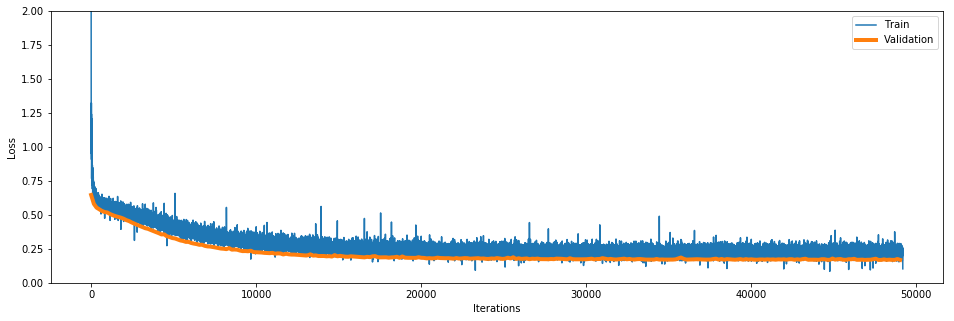

In [25]:
plt.figure(figsize=(16, 5))
plt.plot(loss_hist)
plt.plot(np.arange(len(loss_val_hist))*164, loss_val_hist, linewidth=4)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.ylim((0, 2))
plt.legend(("Train", "Validation"))
plt.show()

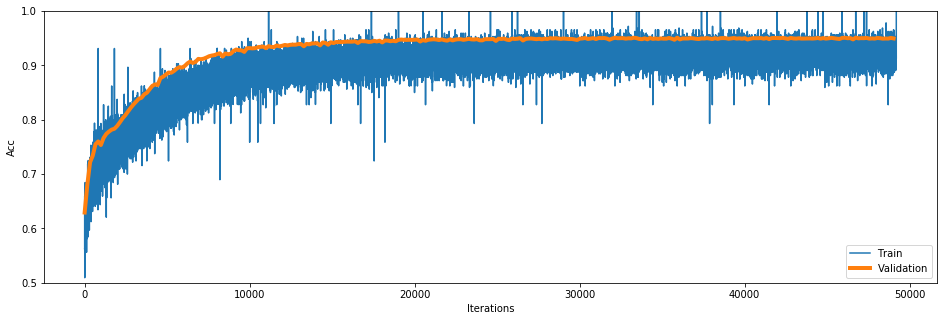

In [26]:
plt.figure(figsize=(16, 5))
plt.plot(acc_hist)
plt.plot(np.arange(len(acc_val_hist))*164, acc_val_hist, linewidth=4)
plt.xlabel("Iterations")
plt.ylabel("Acc")
plt.ylim((0.5, 1))
plt.legend(("Train", "Validation"))
plt.show()

In [27]:
np.argmax(acc_val_hist)

285

In [7]:
(loss_hist, acc_hist, loss_val_hist, acc_val_hist) = torch.load("./models/cell_graph_ADC_vs_SCC_2_11042019/hist.pt")

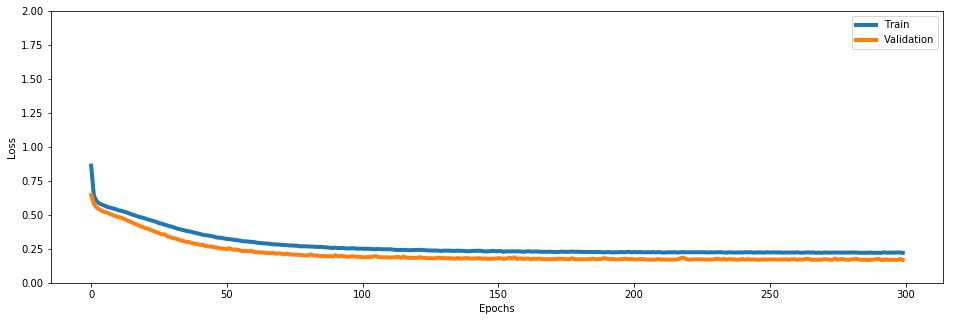

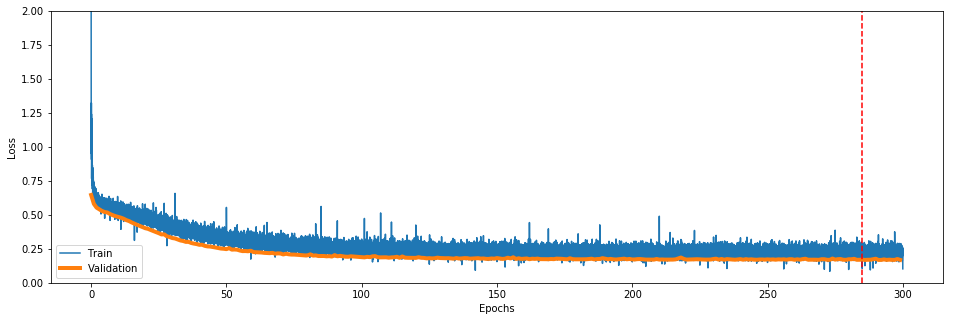

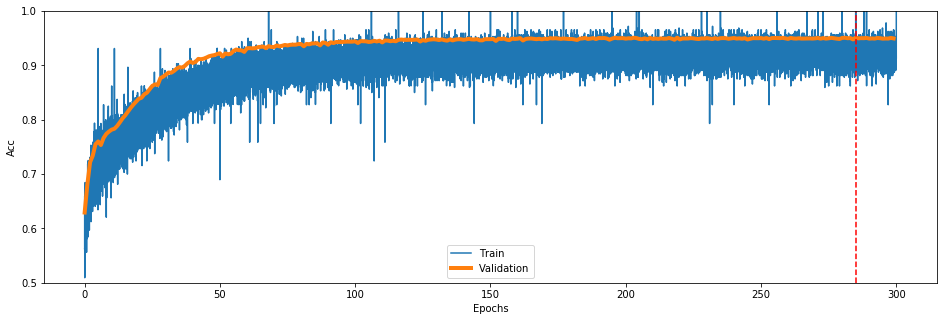

In [9]:
loss_hist_temp = []
for epoch in range(300):
    loss_hist_temp.append(np.average(loss_hist[epoch*164:(epoch+1)*164]))

plt.figure(figsize=(16, 5))
plt.plot(loss_hist_temp, linewidth=4)
plt.plot(np.arange(len(loss_val_hist)), loss_val_hist, linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0, 2))
plt.legend(("Train", "Validation"))
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(np.arange(len(loss_hist))/164, loss_hist)
plt.plot(np.arange(len(loss_val_hist)), loss_val_hist, linewidth=4)
plt.axvline(285, c="red", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0, 2))
plt.legend(("Train", "Validation"))
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(np.arange(len(acc_hist))/164, acc_hist)
plt.plot(np.arange(len(acc_val_hist)), acc_val_hist, linewidth=4)
plt.axvline(285, c="red", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.ylim((0.5, 1))
plt.legend(("Train", "Validation"))
plt.show()

# 5) Inference testing set

In [19]:
# Defind confusion matrix plotting function
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("Accuracy: {}".format((float(cm[0, 0]) + cm[1, 1])/np.sum(cm)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_confusion_matrix_combine(cm, classes,
                                  title='Confusion matrix',
                                  cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with numbers and accuracy together.
    """
    print("Accuracy: {}".format((float(cm[0, 0]) + cm[1, 1])/np.sum(cm)))
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} \n({}%)".format(format(cm[i, j], 'd'), format(cm_norm[i, j]*100, '.1f')),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
device = 1
model = NucleiNet(11, 2, batch=True)
model.to(device)
model.load_state_dict(torch.load("./models/cell_graph_ADC_vs_SCC_2_11042019/epoch_285.pt"))

model.eval()
with torch.no_grad():
    ground_truth = []
    pred_scc_prob = []
    prediction = []
    loss = []
    acc = []
    for i, batch in enumerate(test_loader):
        batch.to(device)
        outputs = model(batch)
        criterion = nn.CrossEntropyLoss()
        loss.append(criterion(outputs, batch.y.squeeze()).item())
        pred_scores = F.softmax(outputs.squeeze()).cpu().detach().numpy()
        pred_labels = np.argmax(pred_scores, axis=1).astype('int')
        true_labels = batch.y.cpu().numpy().squeeze()
        acc.append(np.sum(pred_labels == true_labels)/len(true_labels))
        
        ground_truth.extend(list(true_labels))
        pred_scc_prob.extend(list(pred_scores[:, 1]))
        prediction.extend(list(pred_labels))
        
    # Print and record
    loss = np.average(loss)
    acc = np.average(acc)
    print("Testing set loss: {}, acc: {}".format(loss, acc))

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing set loss: 0.18752502368725077, acc: 0.9449866226978598


Accuracy: 0.9448905582178474
Confusion matrix, without normalization
[[7915  549]
 [ 302 6676]]


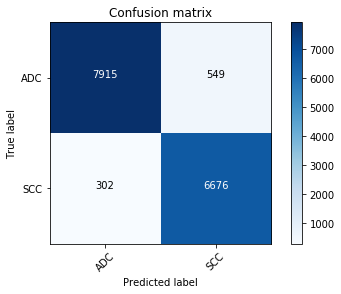

In [21]:
plot_confusion_matrix(confusion_matrix(ground_truth, prediction), ("ADC", "SCC"))

Accuracy: 0.9448905582178474


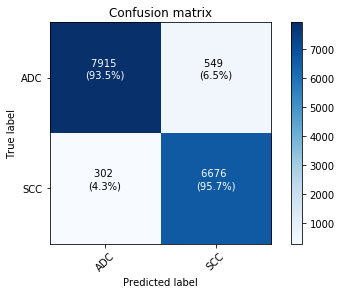

In [22]:
plot_confusion_matrix_combine(confusion_matrix(ground_truth, prediction), ("ADC", "SCC"))

In [23]:
# Explore pid info
test_pids_list = []
for graph in test_list:
    test_pids_list.append(graph.pid.numpy()[0, 0])

In [24]:
for pid in set(test_pids_list):
    # ADC
    graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0]
    if len(graph_ids) != 0:
        true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0 and prediction[i] == 0]
        print("Slide {}, No. graphs: {}, No. predicted ADC {}".format(pid, len(graph_ids), len(true_prediction)))
    
    # SCC
    graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1]
    if len(graph_ids) != 0:
        true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1 and prediction[i] == 1]
        print("Slide {}, No. graphs: {}, No. predicted SCC {}".format(pid, len(graph_ids), len(true_prediction)))
        

Slide 0, No. graphs: 100, No. predicted ADC 99
Slide 0, No. graphs: 65, No. predicted SCC 59
Slide 2, No. graphs: 100, No. predicted ADC 96
Slide 2, No. graphs: 98, No. predicted SCC 97
Slide 5, No. graphs: 99, No. predicted ADC 92
Slide 7, No. graphs: 68, No. predicted SCC 63
Slide 12, No. graphs: 86, No. predicted ADC 76
Slide 16, No. graphs: 98, No. predicted SCC 91
Slide 23, No. graphs: 99, No. predicted ADC 98
Slide 25, No. graphs: 100, No. predicted ADC 86
Slide 27, No. graphs: 91, No. predicted SCC 88
Slide 29, No. graphs: 98, No. predicted SCC 96
Slide 32, No. graphs: 100, No. predicted ADC 100
Slide 35, No. graphs: 58, No. predicted ADC 35
Slide 36, No. graphs: 100, No. predicted ADC 90
Slide 37, No. graphs: 92, No. predicted SCC 86
Slide 41, No. graphs: 100, No. predicted SCC 100
Slide 42, No. graphs: 99, No. predicted SCC 93
Slide 44, No. graphs: 99, No. predicted ADC 90
Slide 45, No. graphs: 86, No. predicted ADC 83
Slide 45, No. graphs: 98, No. predicted SCC 97
Slide 50, N

Patient level accuracy: 172/172, 1.0
Accuracy: 1.0
Confusion matrix, without normalization
[[95  0]
 [ 0 77]]


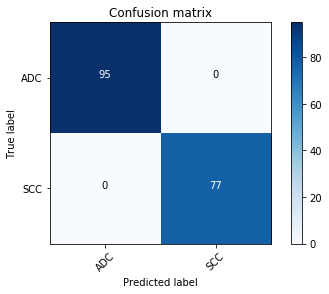

In [25]:
# Patient level accuracy
num_patient = 0
num_true = 0
ground_truth_patient = []
prediction_patient = []
for pid in set(test_pids_list):
    # ADC
    graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0]
    if len(graph_ids) != 0:
        true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0 and prediction[i] == 0]
        if len(true_prediction) >= len(graph_ids)/2.:
            num_true += 1
            prediction_patient.append(0)
        else:
            prediction_patient.append(1)
        num_patient += 1
        ground_truth_patient.append(0)
    
    # SCC
    graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1]
    if len(graph_ids) != 0:
        true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1 and prediction[i] == 1]
        if len(true_prediction) >= len(graph_ids)/2.:
            num_true += 1
            prediction_patient.append(1)
        else:
            prediction_patient.append(0)
        num_patient += 1
        ground_truth_patient.append(1)
print("Patient level accuracy: {}/{}, {}".format(num_true, num_patient, np.round(num_true/num_patient, 3)))
plot_confusion_matrix(confusion_matrix(ground_truth_patient, prediction_patient), ("ADC", "SCC"))

Accuracy: 1.0


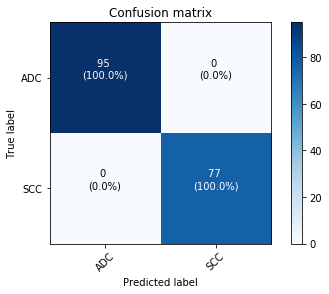

In [41]:
plot_confusion_matrix_combine(confusion_matrix(ground_truth_patient, prediction_patient), ("ADC", "SCC"))

## AUC curve

In [26]:
from sklearn.metrics import roc_curve, auc

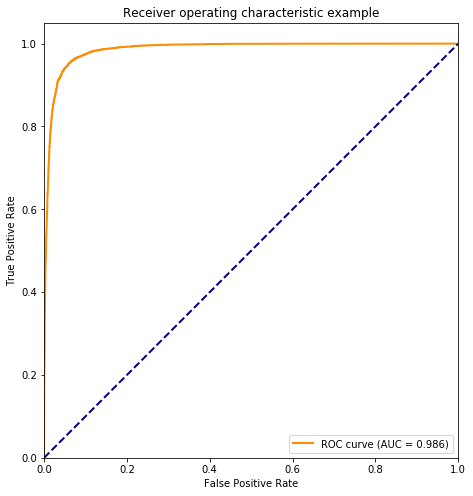

In [27]:
# Patch level
ground_truth = np.array(ground_truth)
pred_scc_prob = np.array(pred_scc_prob)

fpr, tpr, _ = roc_curve(ground_truth, pred_scc_prob)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()

100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


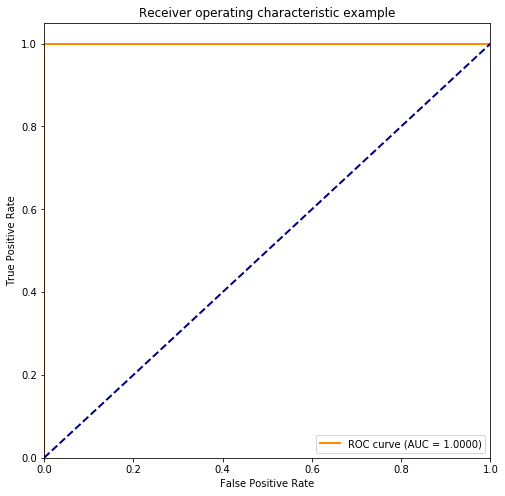

In [28]:
from tqdm import tqdm

# Slide level
fpr_slide = [0]
tpr_slide = [0]
for threshold in tqdm(np.linspace(1, 0, 100)):
    prediction_temp = np.array(pred_scc_prob > threshold)
    num_patient = 0
    num_true = 0
    num_true_positive = 0
    num_false_positive = 0
    num_true_negative = 0
    num_false_negative = 0
    for pid in set(test_pids_list):
        # ADC
        graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0]
        if len(graph_ids) != 0:
            true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 0 and prediction_temp[i] == 0]
            if len(true_prediction) >= len(graph_ids)/2.:
                num_true += 1
                num_true_negative += 1
            else:
                num_false_positive += 1
            num_patient += 1

        # SCC
        graph_ids = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1]
        if len(graph_ids) != 0:
            true_prediction = [i for i, temp in enumerate(test_pids_list) if temp == pid and ground_truth[i] == 1 and prediction_temp[i] == 1]
            if len(true_prediction) >= len(graph_ids)/2.:
                num_true += 1
                num_true_positive += 1
            else:
                num_false_negative += 1
            num_patient += 1
    fpr_slide.append(1.0*num_false_positive/(num_false_positive + num_true_negative))
    tpr_slide.append(1.0*num_true_positive/(num_true_positive + num_false_negative))
fpr_slide.append(1.0)
tpr_slide.append(1.0)
    
roc_auc_slide = auc(fpr_slide, tpr_slide)
    
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr_slide, tpr_slide, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc_slide)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

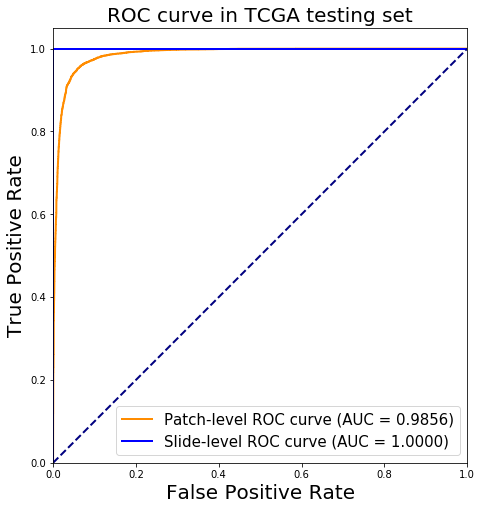

In [29]:
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Patch-level ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot(fpr_slide, tpr_slide, color='blue',
         lw=lw, label='Slide-level ROC curve (AUC = %0.4f)' % roc_auc_slide)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve in TCGA testing set')
plt.legend(loc="lower right", fontsize=15)
ax = plt.gca()
ax.set_aspect("equal")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
plt.show()

# SessionInfo

In [26]:
!pip list

Package             Version    
------------------- -----------
absl-py             0.7.0      
astor               0.7.1      
attrs               19.1.0     
backcall            0.1.0      
bleach              3.1.0      
certifi             2019.3.9   
cycler              0.10.0     
decorator           4.4.0      
defusedxml          0.5.0      
entrypoints         0.3        
environment-kernels 1.1.1      
gast                0.2.2      
grpcio              1.16.0     
h5py                2.8.0      
imageio             2.5.0      
ipykernel           5.1.0      
ipython             7.4.0      
ipython-genutils    0.2.0      
ipywidgets          7.4.2      
isodate             0.6.0      
jedi                0.13.3     
Jinja2              2.10.1     
jsonschema          3.0.1      
jupyter             1.0.0      
jupyter-client      5.2.4      
jupyter-console     6.0.0      
jupyter-core        4.4.0      
Keras               2.2.4      
Keras-Applications  1.0.7      
Keras-Pr